# Implementation of a Newton–Raphson solver for nonlinear elasticity

In this notebook, we will analyse the same problem as in the previous notebook [Hyperelasticity_problem.ipynb](Hyperelasticity_problem.ipynb). However, this time, we will implement or own Newton–Raphson solver, rather than rely on FEniCS's `NonlinearVariationalSolver`.

You need to fill in the blank lines that are indicated as follows
```
# COMPLETE THIS LINE
```

Until you do that, the Notebook will *not* work properly.

## Setting up the problem

The code below is merely a copy/paste of the code from the previous sessions, as we use the same problem to illustrate the implementation of the Newton–Raphson iterations.

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

import dolfin
import ufl
import os.path

%matplotlib inline

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use("seaborn-notebook")

### Parameters of the simulation

Place here the parameters that can be changed without altering the logics of the code.

In [2]:
# Physical mesh : rectangle 2D beam

Lx = 1.0
Ly = Lx / 10     # Dimensions of the beam

nx = 20          # Number of elements in each direction
ny = int(nx / 5) # Number of elements in each direction

Y, nu  =  1e3, 0.3  # Young modulus and Poisson ratio
g  = 1.

load_min, load_max, n_loads = 0.0, 0.1, 40 # Loading schedule
degree = 2 # degree basis function

output_dir = "nr_output"
print(6*Lx**3/((1+nu)*Ly**2) ) # Gamma / t # What is it ???

461.53846153846143


You should not alter the cell below

In [3]:
loads = np.linspace(load_min, load_max, n_loads)

mu    = dolfin.Constant(Y/(2*(1 + nu)))
lmbda = dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 

### Numerical mesh

In [4]:
mesh  = dolfin.RectangleMesh(dolfin.Point(0,0),
                             dolfin.Point(Lx,Ly),
                             nx, ny)

left  = dolfin.CompiledSubDomain("near(x[0],0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx=Lx)

boundary_markers = dolfin.MeshFunction("size_t", 
                                       mesh, 
                                       1, #dim
                                       0) #value

boundary_indices = {"left": 1, "right": 2}
left.mark (boundary_markers, boundary_indices["left"] )
right.mark(boundary_markers, boundary_indices["right"])

ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

### Function space

In [5]:
V_element = dolfin.VectorElement("CG", #usual Lagrangian elements
                                 mesh.ufl_cell(), 
                                 degree=degree) #2

V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u") #name allows to work as with a pointer

### Potential energy

We first define the strain energy of a (compressible) neo-Hookean material.

In [6]:
# Data tensors

def tensors(u):

    """ Function returning a bunch of 
    tensors and other variables."""
    
    I   = ufl.Identity(2)             #2x2 identity matrix
    F   = ufl.variable(I+ufl.grad(u)) #Tensor transformation ref to cur 
    C   = F.T*F                       #Cauchy tensor                   
    Ic  = ufl.tr(C)
    J   = ufl.det(F)                  #Jacobian transformation ref to cur
    E   = 1/2*(C-I)                   #Non-linear strain tensor

    return I, F, C, Ic, J, E

I, F, C, Ic, J, E = tensors(u)

#Hookean potential energy
psi = (mu/2)*(Ic-2)-mu*ufl.ln(J)+(lmbda/2)*(ufl.ln(J))**2

We then define the loading (body forces $\mathbf{B}$).

# Change code to allow one to specify forces vectors as an entry

In [7]:
B = dolfin.Constant((0.0, 0.0))
T = dolfin.Expression(("0.0", "-mu*g*t"), t=0, mu=mu, g=g, degree=0)

We can now define the potential energy and its derivatives w.r.t the displacement $\mathbf{u}$.

In [8]:
# WF
potential_energy = psi*dx - ufl.dot(B, u)*dx - ufl.dot(T, u)*ds(boundary_indices['right'])

residual = ufl.derivative(potential_energy, u, dolfin.TestFunction (V))
jacobian = ufl.derivative(residual        , u, dolfin.TrialFunction(V))

Boundary conditions for a built-in support on the left-hand side.

In [9]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)] #embedded condition to the left (x[0]==0)

### Computing the reference solution

We use the built-in non-linear solver to compute a reference solution, which we will compare to the solution computed with our own NR solver.

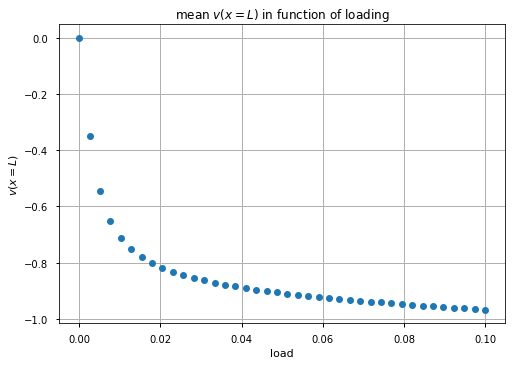

In [10]:
# Function building F(u, v)=0 with F = residual here
problem   = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
solver    = dolfin.NonlinearVariationalSolver(problem)

displ_ref = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0., 0.)))

file_u = dolfin.XDMFFile(os.path.join(output_dir, "u_ref.xdmf"))
file_u.parameters.update({"flush_output":True,
                          "functions_share_mesh":True,
                          "rewrite_function_mesh":False})
for (i, t) in enumerate(loads):
    T.t = t       #add load to downwards gravity force
    solver.solve()
    
    displ_ref[i] = dolfin.assemble(u[1]*ds(boundary_indices["right"]))/Ly 
    #print("t={:+3.3f}, u={:+3.3f}".format(t,displ_ref[i]))
    with file_u as file:
        file.write(u,t)
        
plt.plot(loads, displ_ref, "o")

plt.title(r'mean $v(x=L)$ in function of loading')
plt.xlabel('load')
plt.ylabel(r'$v(x=L)$')

plt.grid(True)

## Implementation of the Newton–Raphson solver

We will discuss the statement below in class.

In [11]:
bcs_homo = bcs

In [12]:
def simple_monitor(iteration, u, norm_u, norm_delta_u, norm_residual):
    
    """ Function displaying information on solution (residual, error, ...). """
    
    print("Iteration: {:3d}, Error: {:3.4e}, Residual: {:3.4e}".format(iteration, norm_delta_u, norm_residual))

# -----------

def plot_monitor(iteration, u, norm_u, norm_delta_u, norm_residual):
    
    """ Function ploting u displacement. """
    
    simple_monitor(iteration, u, norm_u, norm_delta_u, norm_residual)
    
    plt.figure()
    dolfin.plot(u, mode="displacement") 

# -----------

def newton_solver(u, max_iter=100, rtol=1e-6, atol=1e-6, monitor=None):
    
    """ Newton Raphson solver returing converging u value 
    given u (initial guess ??) and nb iterations. """

    delta_u = dolfin.Function(V)
    delta_u.interpolate(dolfin.Constant((0., 0.)))

    for k in range(max_iter):

        # Solve the linearized problem for the increment delta_u with homogenous BCs
        problem_lin = dolfin.LinearVariationalProblem(jacobian, -residual, delta_u, bcs_homo)
        solver_lin  = dolfin.LinearVariationalSolver(problem_lin)
        solver_lin.solve() #value delta_u automatically updated
        
        # Update the solution
        u.assign(u+delta_u) #keeps u and du as 2 separate variables

        # ------------------
        # error calculation
        # ------------------

        # Stopping criterion based on the L2 norm of u and delta_u
        norm_delta_u = dolfin.norm(delta_u, "L2")
        norm_u       = dolfin.norm(      u, "L2")
            
        intR = dolfin.assemble(residual)
        bc.apply(intR)
        norm_residual = dolfin.norm(intR, "L2")
        
        # -----------------
        
        if monitor is not None:
            monitor(k, u, norm_u, norm_delta_u, norm_residual)
        
        else:
            # See for-else statement:
            # https://book.pythontips.com/en/latest/for_-_else.html#else-clause
            # This block is entered only if the above loop completes,
            # which means that the maximum number of iterations has been reached.
            1==1
#             print('You decided to display nothing')
#             raise RuntimeError("could not converge, norm_u {}, norm_delta_u {}".format(norm_u, norm_delta_u)) 

    return k

We are now ready to call our solver, first with a very small load, so that the solution is nearly that of the linear problem, and the algorithm should converge in one iteration.

In [13]:
bc = dolfin.DirichletBC(V, (0.,0.), left) #embedded condition to the left (x[0]==0)

# u = dolfin.Function(V)
u.interpolate(dolfin.Constant((0.0, 0.0)))
T.t = 1E-4

newton_solver(u, max_iter=3, monitor=simple_monitor)

Iteration:   0, Error: 2.3799e-03, Residual: 5.9006e-02
Iteration:   1, Error: 1.9690e-05, Residual: 1.3169e-05
Iteration:   2, Error: 2.0197e-08, Residual: 4.2633e-12


2

Let's try a slightly higher load. We will plot the estimate of the solution at each iteration. It is interesting to observe the iterates converge to the solution.

Iteration:   0, Error: 8.9245e-02, Residual: 5.8511e+01
Iteration:   1, Error: 2.9591e-02, Residual: 1.8414e+01


1

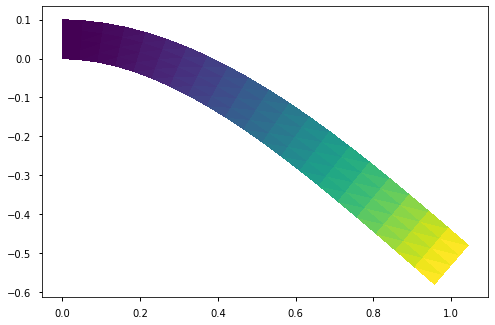

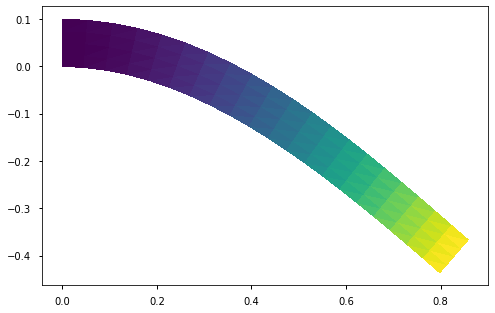

In [14]:
u.interpolate(dolfin.Constant((0., 0.)))
T.t = 1.5*load_max/n_loads

newton_solver(u, max_iter=2, monitor=plot_monitor)

### Illustrating quadratic convergence

We now want to verify that the Newton–Raphson iterations converge quadratically, that is $\epsilon_{n+1} \leq C\epsilon_n^2$, where $\epsilon_n$ denotes the error of the $n$-th iterate. Since we do not know the exact solution of the problem, we will take the last iterate as a reference.

We implement a new `monitor` that keeps a copy of each iterate.

In [15]:
iterates = []

def my_monitor(iteration, u, u_norm, delta_u_norm, residual_norm):
    simple_monitor(iteration, u, u_norm, delta_u_norm, residual_norm)
    iterates.append(u.copy(deepcopy=True))

u.interpolate(dolfin.Constant((0., 0.)))
T.t = 2.5*load_max/n_loads
newton_solver(u, monitor=my_monitor, rtol=1e-10, atol=1e-10)

Iteration:   0, Error: 1.4874e-01, Residual: 1.1391e+02
Iteration:   1, Error: 8.2834e-02, Residual: 1.0833e+02
Iteration:   2, Error: 1.7381e-02, Residual: 2.7039e+01
Iteration:   3, Error: 4.7939e-03, Residual: 1.7587e+01
Iteration:   4, Error: 7.6576e-03, Residual: 5.3403e+00
Iteration:   5, Error: 1.5872e-03, Residual: 3.1750e+00
Iteration:   6, Error: 1.9276e-03, Residual: 1.9434e-01
Iteration:   7, Error: 1.3018e-03, Residual: 3.9919e-02
Iteration:   8, Error: 4.8193e-05, Residual: 2.1781e-05
Iteration:   9, Error: 2.3574e-06, Residual: 7.5431e-08
Iteration:  10, Error: 8.9256e-11, Residual: 2.1632e-12
Iteration:  11, Error: 4.7415e-17, Residual: 1.9989e-12
Iteration:  12, Error: 1.2960e-16, Residual: 2.2435e-12
Iteration:  13, Error: 2.7773e-16, Residual: 2.0637e-12
Iteration:  14, Error: 2.5132e-16, Residual: 2.3343e-12
Iteration:  15, Error: 8.8588e-17, Residual: 2.1509e-12
Iteration:  16, Error: 7.9559e-17, Residual: 2.1893e-12
Iteration:  17, Error: 1.1547e-16, Residual: 2.1

99

**When approaching the solution, we should have** $r^{n+1} = r^{2n}$

In [16]:
L2_errors = np.zeros(len(iterates), dtype=np.float64)
H1_errors = np.zeros_like(L2_errors)
u_ref = iterates[-1]

for i, u_i in enumerate(iterates):
    L2_errors[i] = dolfin.errornorm(u_ref, u_i, 'L2')
    H1_errors[i] = dolfin.errornorm(u_ref, u_i, 'H1')

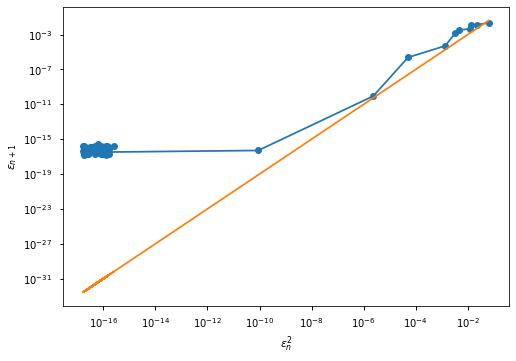

In [24]:
plt.xlabel(r'$\epsilon_n^2$')
plt.ylabel(r'$\epsilon_{n+1}$')

plt.loglog(L2_errors[:-2], L2_errors[1:-1], 'o-')
plt.loglog(L2_errors[:-2], 10*L2_errors[:-2]**2)

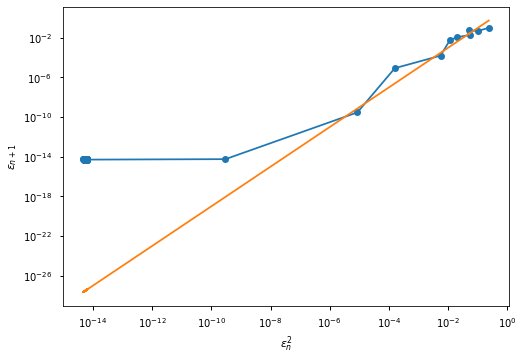

In [26]:
plt.xlabel(r'$\epsilon_n^2$')
plt.ylabel(r'$\epsilon_{n+1}$')

plt.loglog(H1_errors[:-2], H1_errors[1:-1], 'o-')
plt.loglog(H1_errors[:-2], 10*H1_errors[:-2]**2)

**Dependance looks quadratic but with oscillations (stable one as we converge to solution ??)**
    
**Should we prescribe precise condition on mesh where force applied ? Is the form of the force not well integrated or interpolated or else ?**

## Validation of the solver

We now run the whole simulation and compare with the reference solution.

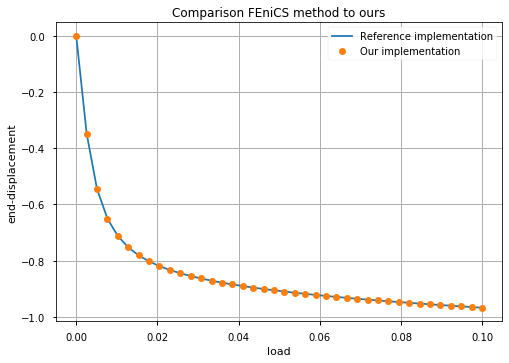

In [27]:
file_u = dolfin.XDMFFile(os.path.join(output_dir, "u.xdmf"))
file_u.parameters.update({"flush_output":True,
                          "functions_share_mesh":True,
                          "rewrite_function_mesh":False})

# initialisation
displ = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0.,0.)))

T.t = 0

for (i, t) in enumerate(loads):
    T.t = t
    newton_solver(u, max_iter=10, monitor=None)
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly 
    #print("t={:+3.3f}, u={:+3.3f}".format(t,displ_ref[i]))
    with file_u as file:
        file.write(u,t)

plt.plot(loads, displ_ref, "-", label='Reference implementation')
plt.plot(loads, displ, 'o', label='Our implementation')

plt.title('Comparison FEniCS method to ours')
plt.ylabel("end-displacement")
plt.xlabel("load")

plt.grid(True)
plt.legend()

#### $L_2$ norm error

In [20]:
e_L2 = np.linalg.norm(displ - displ_ref, ord=2)
print(e_L2)

2.70825156263e-12


**We conclude on the fact our method is equivalent to FEniCS one, namely we manually implemented the same steps.**

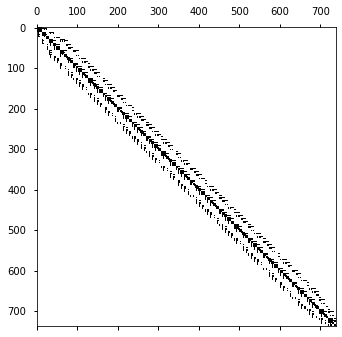

In [21]:
J_mat = dolfin.assemble(jacobian).array()
J_mat
plt.spy(J_mat)